## Tutorial 5: Inception, ResNet and DenseNet

In this tutorial, we will implement and discuss variants of modern CNN architectures. There have been many different architectures been proposed over the past few years. Some of the most impactful ones, and still relevant today, are the following: GoogleNet/Inception architecture (winner of ILSVRC 2014), ResNet (winner of ILSVRC 2015), and DenseNet (best paper award CVPR 2017). All of them were state-of-the-art models when being proposed, and the core ideas of these networks are the foundations for most current state-of-the-art architectures. Thus, it is important to understand these architectures in detail and learn how to implement them.

In [2]:
# Standard libraries
import os, random, matplotlib
import numpy as np

from PIL import Image
from types import SimpleNamespace

# Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Pytorch
import torch as t
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

We will use the same `set_seed` function as in the previous tutorials, as well as the path variables `DATASET_PATH` and `CHECKPOINT_PATH`. Adjust the paths if necessary.

In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g CIFAR10)
DATASET_PATH = './datas'
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed(seed)
        t.cuda.manual_seed_all(seed)
set_seed(42)

device = t.device("cuda:0") if t.cuda.is_available() else t.device("cpu")


We also have pretrained models and Tensorboards (more on this later) for this tutorial, and download them below.

In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "ResNetPreAct.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

Throughout this tutorial, we will train and evaluate the models on the CIFAR10 dataset. This allows you to compare the results obtained here with the model you have implemented in the first assignment.

**As we have learned from the previous tutorial about initialization, it is important to have the data preprocessed with a zero mean.** 

**Therefore, as a first step, we will calculate the mean and standard deviation of the CIFAR dataset:**

In [5]:
train_dataset   = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS      = (train_dataset.data/255.0).mean(axis=(0,1,2))
DATA_STD        = (train_dataset.data/255.0).std(axis=(0,1,2))

print("datas".center(100,"="))
print(train_dataset.data)
print("datas".center(100,"="))
print("DATA_MEANS", DATA_MEANS)
print("DATA_STD", DATA_STD)

Files already downloaded and verified
===============================================datas================================================
[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]


We will use this information to define a `transforms.Normalize` module which will normalize our data accordingly. Additionally, we will use data augmentation during training. This reduces the risk of overfitting and helps CNNs to generalize better. Specifically, we will apply two random augmentations.

First, we will flip each image horizontally by a chance of 50% (`transforms.RandomHorizontalFlip`). The object class usually does not change when flipping an image, and we don’t expect any image information to be dependent on the horizontal orientation. This would be however different if we would try to detect digits or letters in an image, as those have a certain orientation.

The second augmentation we use is called `transforms.RandomResizedCrop`. This transformation scales the image in a small range, while eventually changing the aspect ratio, and crops it afterward in the previous size. Therefore, the actual pixel values change while the content or overall semantics of the image stays the same.

We will randomly split the training dataset into a training and a validation set. The validation set will be used for determining early stopping. After finishing the training, we test the models on the CIFAR test set.



In [6]:
# 다양한 클래스들로 한번에 test_transform을 구성한다, 아래는 Tensor로 변경하고, 정규화를 시켜주는 과정이다.
# DATA_MEANS로 평균을 두고, STD로 표준편차를 나타난대.
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

# For training, we add some agumentation, Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32), scale=(.8,1.),ratio=(.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS,DATA_STD)
                                      ])
        

# Loading the training dataset. We need to split it into a training and validation part.
# We need to do a little trick becuase the validation set should not use the augmentation.
train_dataset   = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
print(train_dataset)
val_dataset     = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform,  download=True)
set_seed(42)
train_set, _    = t.utils.data.random_split(train_dataset, [45000,5000])
set_seed(42)
_, val_set      = t.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set        = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of a data loaders that we can use for various purpose later.
train_loader    = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  pin_memory=True, num_workers=4)
val_loader      = data.DataLoader(val_set,   batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader     = data.DataLoader(test_set,  batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./datas
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1), interpolation=bilinear), antialias=None)
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )
Files already downloaded and verified
Files already downloaded and verified


To verify that our normalization works, we can print out the mean and standard deviation of the single batch. The mean should be close to 0 and the standard deviation close to 1 for each channel:

In [7]:
imgs, _ = next(iter(train_loader))
for i , (datas, labels) in enumerate(train_loader) :
    if i > 0 : 
        break
print("datas".center(100,"="))
print(datas.size())
print("labels".center(100,"="))
print(labels.size())

print("Batch".center(100,"="))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std",  imgs.std(dim=[0,2,3]))

===============================================datas================================================
torch.Size([128, 3, 32, 32])
===============================================labels===============================================
torch.Size([128])
===============================================Batch================================================
Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


Finally, let’s visualize a few images from the training set, and how they look like after random data augmentation:

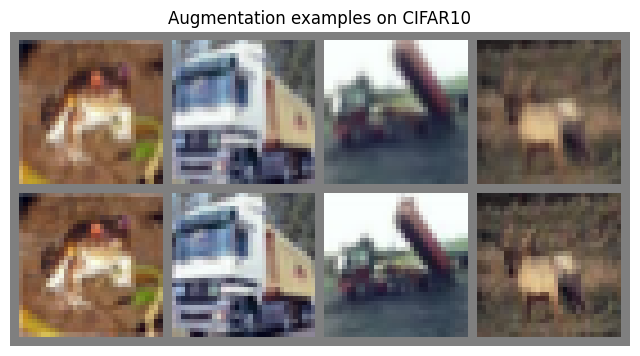

In [8]:
NUM_IMGAES = 4 
images = [train_dataset[idx][0] for idx in range(NUM_IMGAES)]

orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMGAES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid    = torchvision.utils.make_grid(t.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=.5)
img_grid    = img_grid.permute(1,2,0) # (1,2,4) -> (4,1,2)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### PyTorch Lightning
In this notebook and in many following ones, we will make use of the library PyTorch Lightning. PyTorch Lightning is a framework that simplifies your code needed to train, evaluate, and test a model in PyTorch. It also handles logging into TensorBoard, a visualization toolkit for ML experiments, and saving model checkpoints automatically with minimal code overhead from our side. This is extremely helpful for us as we want to focus on implementing different model architectures and spend little time on other code overhead. Note that at the time of writing/teaching, the framework has been released in version 1.6. Future versions might have a slightly changed interface and thus might not work perfectly with the code (we will try to keep it up-to-date as much as possible).

Now, we will take the first step in PyTorch Lightning, and continue to explore the framework in our other tutorials. First, we import the library:

In [9]:
import pytorch_lightning as pl


In [10]:
pl.seed_everything(42)

Global seed set to 42


42

Thus, in the future, we don’t have to define our own `set_seed` function anymore.

In PyTorch Lightning, we define `pl.LightningModule`’s (inheriting from `torch.nn.Module`) that organize our code into 5 main sections:

1. Initialization (`__init__`), where we create all necessary parameters/models

2. Optimizers (`configure_optimizers`) where we create the optimizers, learning rate scheduler, etc.

3. Training loop (`training_step`) where we only have to define the loss calculation for a single batch (the loop of optimizer.zero_grad(), loss.backward() and optimizer.step(), as well as any logging/saving operation, is done in the background)

4. Validation loop (`validation_step`) where similarly to the training, we only have to define what should happen per step

5. Test loop (`test_step`) which is the same as validation, only on a test set.

Therefore, we don’t abstract the PyTorch code, but rather organize it and define some default operations that are commonly used. If you need to change something else in your training/validation/test loop, there are many possible functions you can overwrite (see the [docs](https://pytorch-lightning.readthedocs.io/en/stable/lightning_module.html) for details).

Now we can look at an example of how a Lightning Module for training a CNN looks like:

In [16]:
model_dict = {}

class CIFARModule(pl.LightningDataModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs : 
            model_name      - Name of the model/CNN to run, Used for create the model (see the function below)
            model_hparams   - Hyperparameters for the model, as dictionary
            optimizer_name  - Name of the optimizer to use. Currently supported : Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary, This includes learning rate, weight decay, etc.
        """

        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = t.zeros((1,3,32,32),dtype=t.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)
    
    def configure_optimizers(self):
        # We will support Adam for SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implemetation of weight decay
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD": 
            optimizer = optim.SGD(
                self.parameters(), **self.hparams.optimizer_hparams)
        else : 
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        scheduler = optim.lr_scheduler.MultiplicativeLR(
            optimizer, milestones=[100,150], gamma=.1)
        
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "Batch" is the output of the training data loader.
        imgs, labels = batch                                # train_loader에서 datas, labels로 나누는것 
        preds        = self.model(imgs)                     # datas들을 원하는 models에 넣어 preds을 구한다.
        loss         = self.loss_module(preds, labels)      # training된 models값의 preds와 labels를 비교하는
                                                            # loss 모듈을 생성한다. Classification같은 경우 CrossEntropy가 대표적으로
                                                            # 사용된다.
        # 최종적으로 출력된 tensor array에서 최고값을 찾아내고 
        # 해당 위치가 labels의 array와 동일하다면
        # 이를 True, False로 받는데 이걸 다시 float으로 변환시키고 
        # 이 평균값을 구한다.
        # 해당 모델에 대한 평균값은 128 batch당 128개의 labels에 대한 평균을 구한다는 뜻이다.
        acc          = (preds.argmax(dim=-1) == labels).float().mean()
        
        # Logs the accuracy per epoch to tensorboard (wighted average over batches)
        self.log('train_acc' , acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, bathc_idx):
        imgs, labels = batch
        preds        = self.model(imgs).argmax(dim=-1)
        acc          = (labels == preds).float().mean()

        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds        = self.model(imgs).argmax(dim=-1)
        acc          = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc',acc)
        


We see that the code is organized and clear, which helps if someone else tries to understand your code.

Another important part of PyTorch Lightning is the concept of callbacks. Callbacks are self-contained functions that contain the non-essential logic of your Lightning Module. 

They are usually called after finishing a training epoch, but can also influence other parts of your training loop. 

For instance, we will use the following two pre-defined callbacks: `LearningRateMonitor` and `ModelCheckpoint`. 

The learning rate monitor adds the current learning rate to our TensorBoard, which helps to verify that our learning rate scheduler works correctly. 

The model checkpoint callback allows you to customize the saving routine of your checkpoints. For instance, how many checkpoints to keep, when to save, which metric to look out for, etc. We import them below:

In [12]:
# Callbacks 
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

To allow running multiple different models with the same Lightning module, we define a function below that maps a model name to the model class. At this stage, the dictionary `model_dict` is empty, but we will fill it throughout the notebook with our new models.

In [17]:
def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else :
        assert False, f"Unknown model name \'{model_name}'. Available models are : {str(model_dict.keys())}"


Similarly, to use the activation function as another hyperparameter in our model, we define a “name to function” dict below:

In [18]:
act_fn_by_name = {
    'tanh' : nn.Tanh,
    'relu' : nn.ReLU,
    'leakyrelu' : nn.LeakyReLU,
    'gelu'      : nn.GELU
}


$ReLU : \qquad \qquad f(x) = max(0,x)$


$Leaky\ ReLU : \quad f(x) = max(0.01x,x)$


$ELU\ : \qquad \qquad\ f(x) = \begin{cases}
x,\ \ \ \ \ \ \ \ \ \ \ \ \ \ if\ x>0\\
a(e^x-1),\  if\ x\leq0
\end{cases}$

$Swish\ : \qquad \quad \ \ f(x) = x \cdot \sigma(x)\ \ \ (where\ \sigma = sigmoid\ function)$

$GELU(x) = xP(X \leq x) = x\Phi(x) = x \cdot \frac{1}{2} \left[1+erf(x/\sqrt{2})\right]$ 

###### if $X \sim \mathcal{N}(0,1) \to 0.5x\left(1+\tanh \left[\sqrt{2/\pi}(x+0.044715x^3)\right]\right) \quad or\quad x\sigma(1.702x)$

<img src='./img/스크린샷 2023-01-29 오후 3.11.51.png' width=50% hegith=50%>

If we pass the classes or objects directly as an argument to the Lightning module, we couldn’t take advantage of PyTorch Lightning’s automatically hyperparameter saving and loading.

Besides the Lightning module, the second most important module in PyTorch Lightning is the `Trainer`. 

The trainer is responsible to execute the training steps defined in the Lightning module and completes the framework. Similar to the Lightning module, you can override any key part that you don’t want to be automated, but the default settings are often the best practice to do. For a full overview, see the documentation. The most important functions we use below are:

- `trainer.fit`: Takes as input a lightning module, a training dataset, and an (optional) validation dataset. This function trains the given module on the training dataset with occasional validation (default once per epoch, can be changed)

- `trainer.test`: Takes as input a model and a dataset on which we want to test. It returns the test metric on the dataset.

For training and testing, we don’t have to worry about things like setting the model to eval mode (`model.eval()`) as this is all done automatically. See below how we define a training function for our models:

In [19]:
def train_model(model_name, save_name = None, **kwargs):
    """
    InPuts : 
            model_name          - Name of the model you want to run. Is used to look up the class in 'model_dict'
            save_name(optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None :
        save_name = model_name

    # Create a PyTorch Lighting trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                         # where to save models
                        accelerator='gpu' if str(device).startswith('cuda') else "cpu",                     # We run on a GPU
                        devices=1,                                                                          # How many GPUs/CPUs we want to use
                        max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                        callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                        LearningRateMonitor('epoch')],                                                      # Log learning rate every epoch
                        enable_progress_bar=True)                                                           # Set to False if you do not want a progress bar
    trainer.logger._log_graph = True            # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None    # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename) : 
        print(f"Found pretrained model at {pretrained_filename}, loading ...")
        model = CIFARModule.load_from_checkpoint(pretrained_files)
    else : 
        # Load할 Model이 없다면, 42로 설정하고
        pl.seed_everything(42)
        # 만든 모듈에 모델을 넣어줍니다.
        # **kwargs : 하이퍼 파라미터, 옵티마이저, 옵티마이저 하이퍼 파라미터 넣어줍니다.
        model = CIFARModule(model_name=model_name, **kwargs)
        
        # trianing the model with validation sets
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after trainig
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) 

    # Test best model on validation and test set
    val_result  = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result      = {"test" : test_result[0]["test_acc"], "val" : val_result[0]["test_acc"]}

    return model, result


### Inception

The [GoogleNet](https://arxiv.org/abs/1409.4842), proposed in 2014, won the ImageNet Challenge because of its usage of the Inception modules. In general, we will mainly focus on the concept of Inception in this tutorial instead of the specifics of the GoogleNet, as based on Inception, there have been many follow-up works (Inception-v2, Inception-v3, [Inception-v4](https://arxiv.org/abs/1602.07261), [Inception-ResNet](https://arxiv.org/abs/1602.07261),…). The follow-up works mainly focus on increasing efficiency and enabling very deep Inception networks. However, for a fundamental understanding, it is sufficient to look at the original Inception block.

An Inception block applies four convolution blocks separately on the same feature map: a 1x1, 3x3, and 5x5 convolution, and a max pool operation. This allows the network to look at the same data with different receptive fields. 

**Of course, learning only 5x5 convolution would be theoretically more powerful. However, this is not only more computation and memory heavy but also tends to overfit much easier.**

The overall inception block looks like below (figure credit - Szegedy et al.):

<p align='center'>
    <img src='./img/스크린샷 2023-01-30 오후 2.23.19.png' width=50% height=50%>
</p>

The additional 1x1 convolutions before the 3x3 and 5x5 convolutions are used for dimensionality reduction. This is especially crucial as the feature maps of all branches are merged afterward, and we don’t want any explosion of feature size. As 5x5 convolutions are 25 times more expensive than 1x1 convolutions, we can save a lot of computation and parameters by reducing the dimensionality before the large convolutions.

We can now try to implement the Inception Block ourselves:



In [22]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs : 
            c_in    - Number of input feature maps from the previous layers
            c_red   - Dictionary with keys "3x3" and "5x5" spcifying the output of the dimensionality reducing 1x1 convolutions
            c_out   - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn  - Activation class constructor (e.g nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn. Sequential(
            # nn.Conv2d(input, output, with 1x1 kernel_size)
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            # nn.BatchNorm2d(number_of_channels, )
            nn.BatchNorm2d(c_out["1x1"]),
            # add activations Layers
            act_fn(),            
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red['3x3'], c_out['3x3'], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out['3x3'],
            act_fn())
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red['5x5'], kernel_size=1),
            nn.BatchNorm2d(c_red['5x5']),
            act_fn(),
            nn.Conv2d(c_red['5x5'], c_out['5x5'], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out['5x5']),
            act_fn()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out['max'],kernel_size=1),
            nn.BatchNorm2d(c_out['max']),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = t.cat(x_1x1, x_3x3, x_5x5, x_max)
        return x_out

    # 3x3 convolution branch
    self.conv_3x3 = nn.Sequential(
        nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
        nn.BatchNorm2d(c_red["3x3"]),
        act_fn(),
        nn.Conv2d(c_red['3x3'], c_out['3x3'], kernel_size=3, padding=1),
        nn.BatchNorm2d(c_out['3x3'],
        act_fn())
    )


<p align='center'>
    <img src='./img/스크린샷 2023-01-30 오후 7.35.15.png' width=20% height=20%/>
</p>

The GoogleNet architecture consists of stacking multiple Inception blocks with occasional max pooling to reduce the height and width of the feature maps. The original GoogleNet was designed for image sizes of ImageNet (224x224 pixels) and had almost 7 million parameters. As we train on CIFAR10 with image sizes of 32x32, we don’t require such a heavy architecture, and instead, apply a reduced version. The number of channels for dimensionality reduction and output per filter (1x1, 3x3, 5x5, and max pooling) need to be manually specified and can be changed if interested. The general intuition is to have the most filters for the 3x3 convolutions, as they are powerful enough to take the context into account while requiring almost a third of the parameters of the 5x5 convolution.